In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from data_collector import Omie

from potenciala import BucketMethod, FigureShape, SingleTimeSeries, VectorTimeSeries
from stochastic import (EulerMaruyama, ConstantDiffusionMultivariate, SpatialDifferenceDriftMultivariate, 
                        SpatialDiffusionUnivariate, SpatialDriftMultivariate)

In [3]:
# uncomment this to obtain most up-to-date day ahead market timeseries
#df = Omie.download_period_file(filename="marginalpdbc", start_year=2016, end_year=2021)
#df = Omie.include_old_file(df=df, filename="marginalpdbc_2002_2015.csv")

In [4]:
df_raw = pd.read_csv("day_ahead_market_20211005.csv")

In [5]:
# filter data before 2004 (missing dates in 2003) and beyond 2021
df = df_raw.query("year >= 2004 & year <= 2020")

### Univariate timeseries

In [6]:
s_1 = SingleTimeSeries(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Round, bin_size=1)
s_025 = SingleTimeSeries(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)

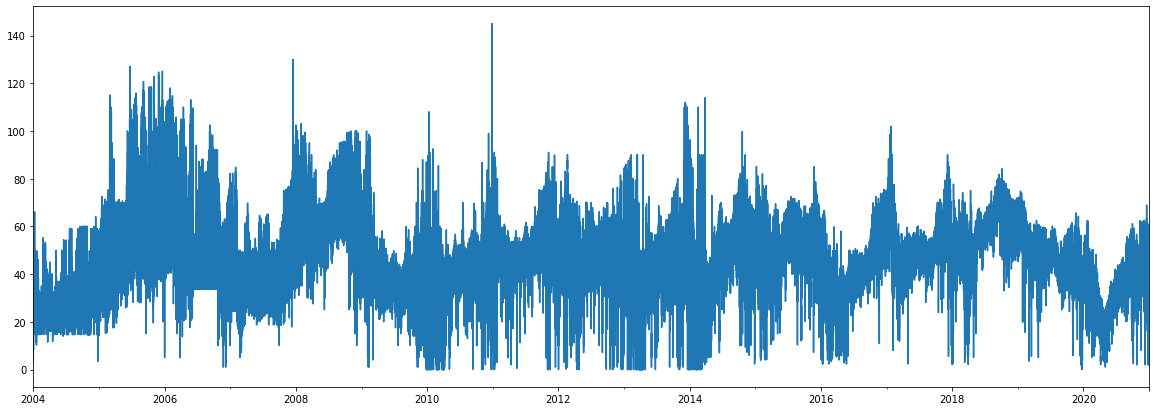

In [7]:
s_1.plot_ts()

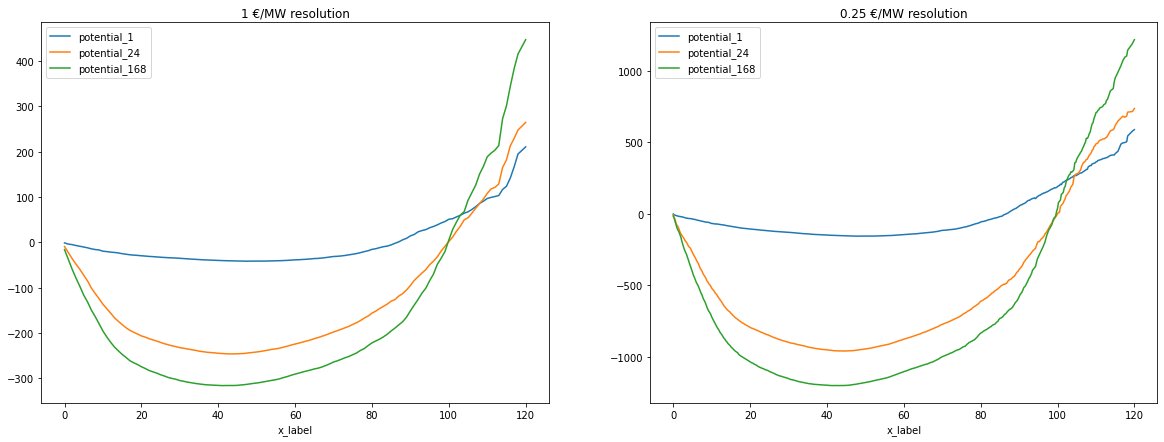

In [8]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 7))
s_1.potential.loc[:120].plot(ax=ax0)
s_025.potential.loc[:120].plot(ax=ax1)
ax0.set_title("1 €/MW resolution")
ax1.set_title("0.25 €/MW resolution")
plt.show()

### Include all history or last n years

In [ ]:
# Compare potential across different years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
for year in years:
    df_year = df[df["year"] == year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compare potential across different years with minimum
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
for year in years:
    df_year = df[df["year"] == year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compute accumulative years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
years = years[::-1]
for year in years:
    df_year = df[df["year"] >= year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Compute accumulative years with minimum
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2021)
years = years[::-1]
for year in years:
    df_year = df[df["year"] >= year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Check n-year period
n = 4
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2002, 2022, n)
for year in years:
    df_year = df[(df["year"] >= year) & (df["year"] < year + n)]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# Check n-year period divided by minimum
n = 4
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2002, 2022, n)
for year in years:
    df_year = df[(df["year"] >= year) & (df["year"] < year + n)]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

In [ ]:
# plot mean drift and diffusion
_ = s_1.drift.mean["drift_1"].iloc[:120].plot()

In [ ]:
_ = s_1.diffusion.mean["diffusion_1"].iloc[:120].plot()

In [ ]:
a = s_1.drift.mean["drift_1"]
a = a.reindex(np.arange(0, a.index.max() + 20)).fillna(0)
b = s_1.diffusion.mean["diffusion_1"]
b = b.reindex(np.arange(0, b.index.max() + 20)).fillna(0)

x_df = s_1.df[(s_1.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[0]

In [ ]:
drift = SpatialDriftMultivariate(df=a.to_frame())
diffusion = SpatialDiffusionUnivariate(df=b.to_frame())

em_1 = EulerMaruyama(num_sim=1000, period=24*6, delta_t=1, nu=0, drift=drift, diffusion=diffusion)

In [ ]:
sim_df = em_1.simulate(x0=np.array([x_0]), random_seed=124)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[:,  :em_1.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
plt.show()

### Multivariate  timeseries $D_{1}^h(X_{d}^h)$ 

In [9]:
s = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.Round, bin_size=1, 
                     diff_matrix_xi_xj_computation=False)

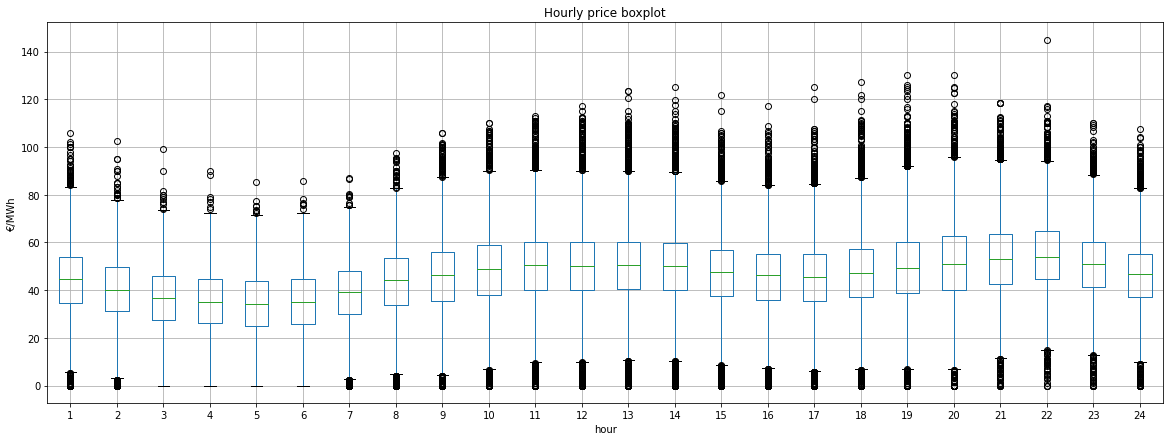

In [10]:
s.plot_hourly_boxplot()

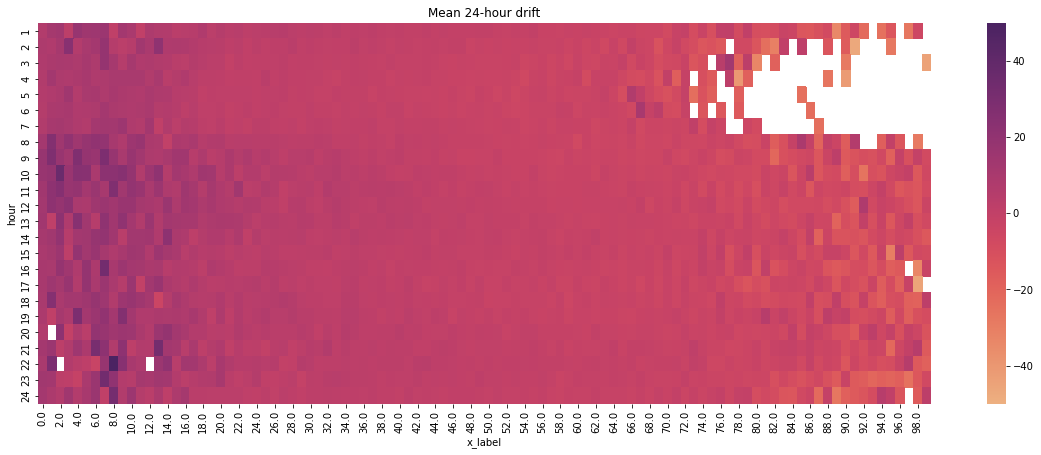

In [11]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s.drift_hour_x.iloc[:, :100], ax=ax, cmap='flare', vmin=-50, vmax=50)
ax.set_title("Mean 24-hour drift")
fig.show()

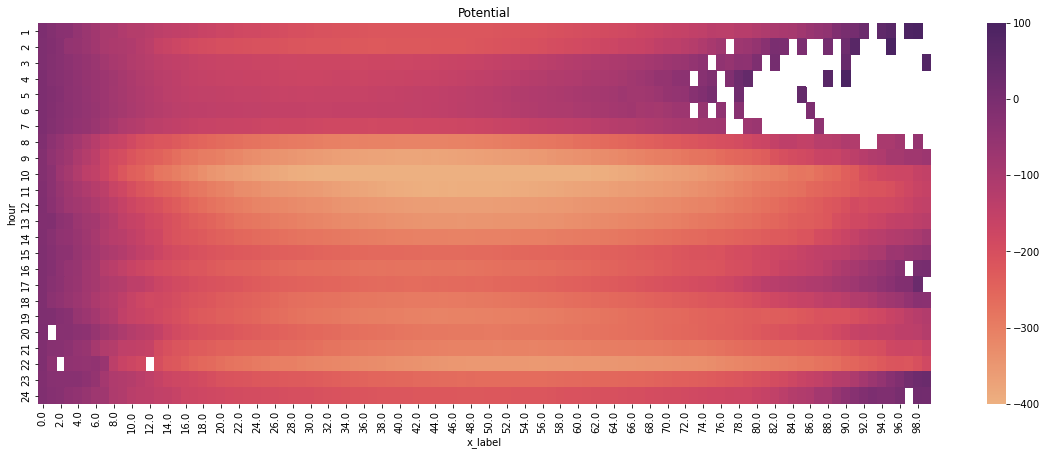

In [12]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s.potential_hour_x.iloc[:, :100], ax=ax, cmap='flare', vmin=-400, vmax=100)
ax.set_title("Potential")
fig.show()

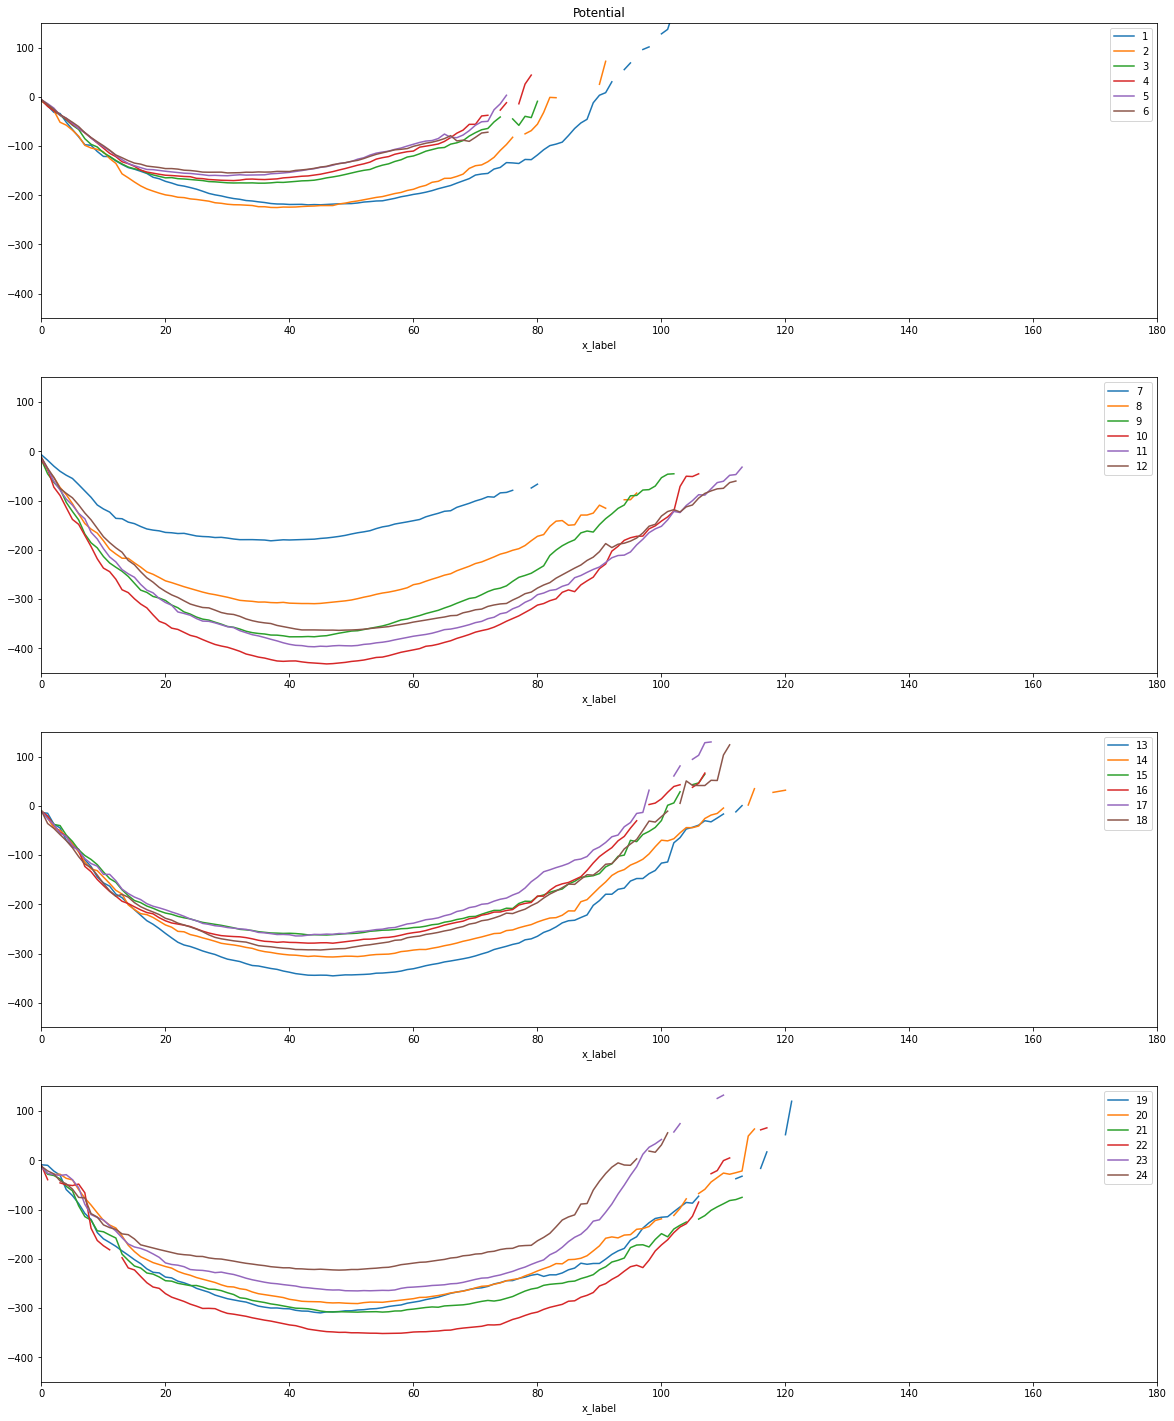

In [13]:
m = 6
n = int(24/m)
fig, ax = plt.subplots(n, 1, figsize=(20, 25))
for i in range(n):
    s.potential_hour_x.loc[i*m+1:(i+1)*m].T.plot(ax=ax[i])
    ax[i].legend(loc=1)
    ax[i].set_xlim(0, 180)
    ax[i].set_ylim(-450, 150)
ax[0].set_title("Potential")
fig.show()

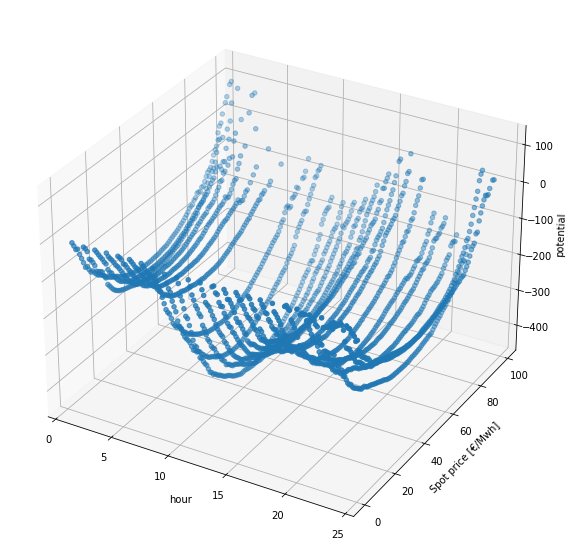

In [14]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))
potential = s.potential_hour_x.iloc[:, :100].stack().reset_index()
ax.scatter(potential.iloc[:, 0], potential.iloc[:, 1], potential.iloc[:, 2])
ax.set_xlabel("hour")
ax.set_ylabel("Spot price [€/Mwh]")
ax.set_zlabel("potential")
fig.show()

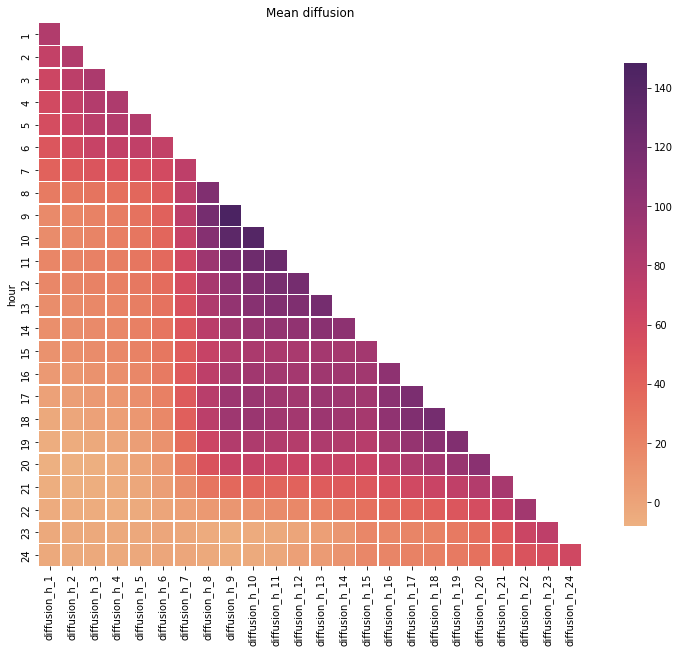

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s.diffusion_matrix, dtype=bool), k=1)
sns.heatmap(s.diffusion_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

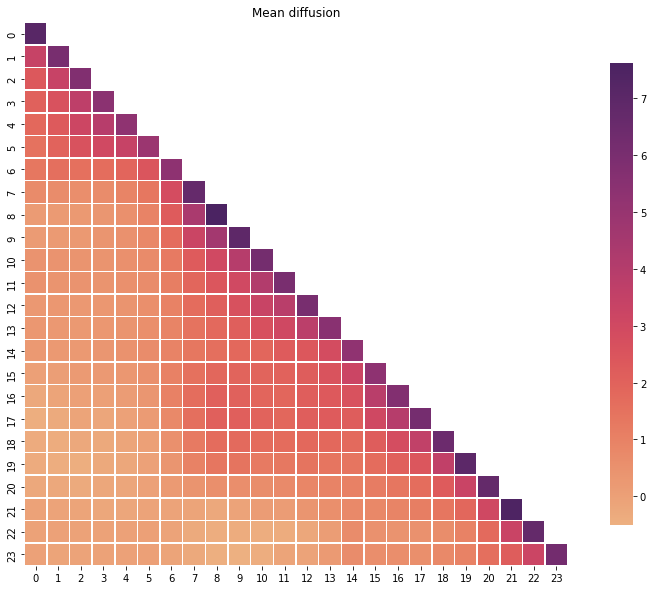

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s.sqrt_diff_matrix, dtype=bool), k=1)
sns.heatmap(s.sqrt_diff_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

#### Simulation with $D_{1}^h(X_{d}^h)$ and diagonal $D^{2}$

In [ ]:
x_df = s.df[(s.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[:24].values

In [ ]:
spatial_drift = SpatialDriftMultivariate(df=s.drift_hour_x)
diag_diff_matrix = pd.DataFrame(np.sqrt(np.diag(np.diag(s.diffusion_matrix))))
diag_diffusion = ConstantDiffusionMultivariate(df=diag_diff_matrix)

em_2 = EulerMaruyama(num_sim=1000, period=6, delta_t=1, nu=0, drift=spatial_drift, diffusion=diag_diffusion)

In [ ]:
sim_df = em_2.simulate(x0=x_0, random_seed=124)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_2.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 120)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^{h}(X_d^h)$ and diagonal $D_2$")
plt.show()

#### Simulation with $D_{1}^h(X_{d}^h)$ and non-diagonal constant $D^{2}$

In [ ]:
x_df = s.df[(s.df["date"] >= "2020-12-10")].iloc[:24*6]
x_0 = x_df["spain"].iloc[:24].values

In [ ]:
spatial_drift = SpatialDriftMultivariate(df=s.drift_hour_x)
cte_diffusion = ConstantDiffusionMultivariate(df=pd.DataFrame(s.sqrt_diff_matrix))

em_3 = EulerMaruyama(num_sim=1000, period=6, delta_t=1, nu=0, drift=spatial_drift, diffusion=cte_diffusion)

In [ ]:
sim_df = em_3.simulate(x0=x_0, random_seed=124)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[24:, : em_3.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[24:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 120)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation with $D_1^h(X_d^h)$ and non-diagonal $D_2$")
plt.show()

### Multivariate timeseries  - $D_{1}^{h}(X_{d}^h - X_{d-1}^h)$ 

In [ ]:
s_back_drift = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.Round, bin_size=1, x_transformation="back_drift")

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.samples_hour_x.iloc[:, :200], ax=ax, cmap='flare')#, vmin=-40, vmax=40)
ax.set_title("Samples 24-hour drift")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.drift_hour_x, ax=ax, cmap='flare')#, vmin=-40, vmax=40)
ax.set_title("Mean 24-hour drift")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s_back_drift.potential_hour_x, ax=ax, cmap='flare')
ax.set_title("Potential")
fig.show()

In [ ]:
m = 6
n = int(24/m)
fig, ax = plt.subplots(n, 1, figsize=(20, 25))
for i in range(n):
    s_back_drift.potential_hour_x.loc[i*m+1:(i+1)*m].T.plot(ax=ax[i])
    ax[i].legend(loc=1)
    ax[i].set_xlim(-80, 80)
    #ax[i].set_ylim(-450, 150)
ax[0].set_title("Potential")
fig.show()

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))
potential = s_back_drift.potential_hour_x.stack().reset_index()
ax.scatter(potential.iloc[:, 0], potential.iloc[:, 1], potential.iloc[:, 2])
ax.set_xlabel("hour")
ax.set_ylabel("X")
ax.set_zlabel("potential")
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(s_back_drift.diffusion_matrix, dtype=bool), k=1)
sns.heatmap(s_back_drift.diffusion_matrix, cmap="flare", mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.85})
ax.set_title("Mean diffusion")
fig.show()

#### Simulation with $D_{1}^h(X_{d}^h - X_{d-1}^h)$ and non-diagonal constant $D^{2}$

In [ ]:
x_df = s_back_drift.df[(s_back_drift.df["date"] >= "2020-12-09")].iloc[:24*7]
t_0 = x_df["spain"].iloc[:24].values
t_1 = x_df["spain"].iloc[24:48].values
x_0 = np.vstack([t_0, t_1]).T

In [ ]:
spatial_diff_drift = SpatialDifferenceDriftMultivariate(df=s_back_drift.drift_hour_x)
cte_diffusion = ConstantDiffusionMultivariate(df=pd.DataFrame(s_back_drift.sqrt_diff_matrix))

em_4 = EulerMaruyama(num_sim=1000, period=7, delta_t=1, nu=0, drift=spatial_diff_drift, diffusion=cte_diffusion)

In [ ]:
sim_df = em_4.simulate(x0=x_0, random_seed=124)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.iloc[48:, : em_4.num_sim//2].plot(alpha=0.05, ax=ax, legend=False)
sim_df.mean(axis=1).iloc[24:].plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].iloc[24:].plot(lw=1.5, color="blue", ax=ax)
sim_df.iloc[48:, :].quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
ax.set_xlabel("hour")
ax.set_ylim(0, 120)
ax.set_ylabel("€/MWh")
ax.set_title("Day ahead electricity price simulation for $D_1^h(X_d^h - X_{d-1}^h)$ and non-diagonal $D_2$")
plt.show()

## Potential spline fit

In [17]:
from scipy import interpolate

In [ ]:
s_1.df[["spain", "drift_24"]].plot.scatter(x="spain", y="drift_24", alpha=0.1)

In [ ]:
# example spline interpolation
x = s_1.potential["potential_1"].index.values
y = s_1.potential["potential_1"].values

xnew = np.arange(0, 150)

# smooth value (s) is s => np.ones(len(x)) * (y - interpolate.splev(x, tck, der=0))**2)
# larger s values leads to higher errors but a smoother function
smooth_values = [0, 10, 100, 1000, 10000, 100000] + [len(x) - np.sqrt(2*len(x))]
smooth_values.sort()
for sm_v in smooth_values:
    tck = interpolate.splrep(x, y, s=sm_v, k=3)
    ynew = interpolate.splev(xnew, tck, der=0)
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    ax0.plot(xnew, ynew, 'b', x, y, 'r')
    
    yder = interpolate.splev(xnew, tck, der=1)
    ax1.plot(xnew, (-1)*yder)
    fig.suptitle(f"s = {sm_v}")
    

In [ ]:
s.drift_hour_x.loc[10].plot()

In [ ]:
s.potential_hour_x.loc[10].plot()

### Cubic splines - Potential as a function of spot price

In [ ]:
w_c = s.df.groupby(["hour", "x_label"])["drift_24"].count().unstack(-1).loc[10].dropna()
w_index = w_c[w_c > 1].index
w = s.df.groupby(["hour", "x_label"])["drift_24"].std().unstack(-1).loc[10].dropna()
w = w.loc[w_index].values

potential = s.potential_hour_x.loc[10]
potential = potential.dropna().loc[w_index]

x = potential.index.values
y = potential.values

xnew = np.arange(0, 150)

smooth_values = [0, 10, 100, 1000, 5000, 10000, 100000] + [len(x) - np.sqrt(2*len(x))]
#smooth_values = [10000]
smooth_values.sort()
for sm_v in smooth_values:
    tck = interpolate.splrep(x, y, s=sm_v, k=3)
    ynew = interpolate.splev(xnew, tck, der=0)
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 3))
    ax0.plot(xnew, ynew, 'b', x, y, 'r')
    ax0.set_title("potential")
    
    yder = interpolate.splev(xnew, tck, der=1)
    ax1.plot(xnew, (-1)*yder)
    ax1.set_title("drift")
    fig.suptitle(f"s = {sm_v}")


In [ ]:
w_c = s.df.groupby(["hour", "x_label"])["drift_24"].count().unstack(-1).loc[10].dropna()
w_index = w_c[w_c > 1].index
w = s.df.groupby(["hour", "x_label"])["drift_24"].std().unstack(-1).loc[10].dropna()
w = w.loc[w_index].values

potential = s.potential_hour_x.loc[10]
potential = potential.dropna().loc[w_index]

x = potential.index.values
y = potential.values

xnew = np.arange(0, 150)

smooth_values = [0, 10, 100, 1000, 5000, 10000, 100000] + [len(x) - np.sqrt(2*len(x))]
#smooth_values = [10000]
smooth_values.sort()
for sm_v in smooth_values:
    us = interpolate.UnivariateSpline(x, y, k=3, s=sm_v, ext=3)
    ynew = us(xnew, nu=0, ext=3)
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 3))
    ax0.plot(xnew, ynew, 'b', x, y, 'r')
    ax0.set_title("potential")
    
    yder = us(xnew, nu=1, ext=0)
    ax1.plot(xnew, (-1)*yder)
    ax1.set_title("drift")
    fig.suptitle(f"s = {sm_v}")

In [ ]:
fig, axis = plt.subplots(6, 4, figsize=(20, 20))

xnew = np.arange(0, 150) 
for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        hour = 1 + i*4+j
        
        w_c = s.df.groupby(["hour", "x_label"])["drift_24"].count().unstack(-1).loc[hour].dropna()
        w_index = w_c[w_c > 1].index
        w = s.df.groupby(["hour", "x_label"])["drift_24"].std().unstack(-1).loc[hour].dropna()
        w = w.loc[w_index].values
        
        potential = s.potential_hour_x.loc[hour].loc[w_index]
        potential.plot(ax=ax, color='r')
        potential = potential.dropna()
        x = potential.index.values
        y = potential.values
        
        tck = interpolate.splrep(x, y, s=6*10**3, k=2)
        
        ynew = interpolate.splev(xnew, tck, der=0)
        
        ax.plot(xnew, ynew, 'b')
        ax.set_title(f"potential hour - {hour}")

### Fit mean drift for data until 10/2021

In [ ]:
s.df.query("hour == 17").plot.scatter(x="spain", y="drift_24")

In [ ]:
foo = s.df.query("hour == 17")[["spain", "drift_24"]].dropna()

In [ ]:
foo = foo.groupby("x_label")["drift_24"].mean()

In [ ]:
tck = interpolate.splrep(foo.index.values, foo.values, s=10**6, k=3)

In [ ]:
x_new = np.arange(0, 250, 0.25)
y_new = interpolate.splev(x_new, tck, der=0)

In [ ]:
fig, ax = plt.subplots()
foo.plot.scatter(x="spain", y="drift_24", alpha=0.1, ax=ax)
ax.plot(x_new, y_new, color="orange")

### Gaussian kde

In [ ]:
from scipy import integrate, stats
from matplotlib.lines import Line2D 

$$D_1^{h}$$

In [143]:
def plot_gaussian_kde_mean_price_change(ax, h_stats):
    
    ax.plot(h_stats["values"][0], h_stats["values"][1], 'k.', markersize=2, alpha=0.1)
    ax.imshow(np.rot90(h_stats["Z"]), 
              cmap=plt.cm.gist_earth_r, 
              extent=[h_stats["xmin"], h_stats["xmax"], h_stats["ymin"], h_stats["ymax"]],
              aspect="auto")
    ax.plot(h_stats["x_empirical_price_change"].index, 
            h_stats["x_empirical_price_change"].values, 
            lw=2, color="red", alpha=0.7)
    ax.plot(h_stats["x_range"], h_stats["x_mean_price_change"], lw=2, color="blue")
    
def plot_potential(ax, h_stats):
    
    ax.plot(h_stats["x_empirical_price_change"].index, 
            (-1)*h_stats["x_empirical_price_change"].cumsum(), color="red", alpha=0.7)
    ax.plot(h_stats["x_range"], (-1)*h_stats["x_mean_price_change"].cumsum(), color="blue")

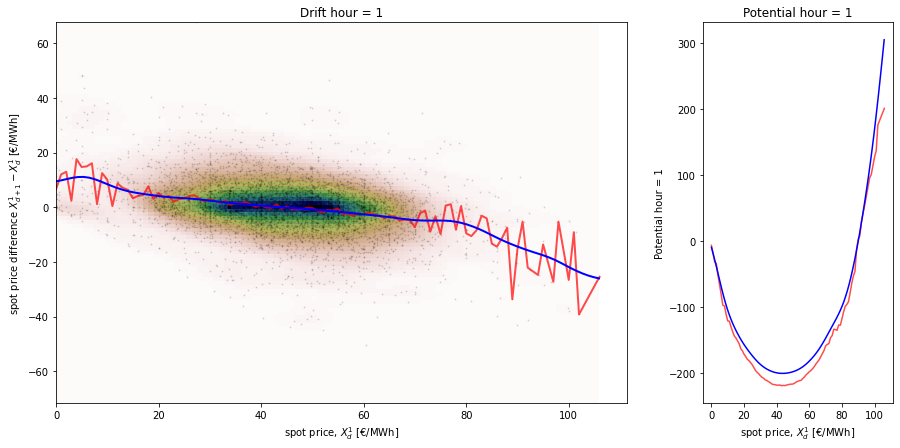

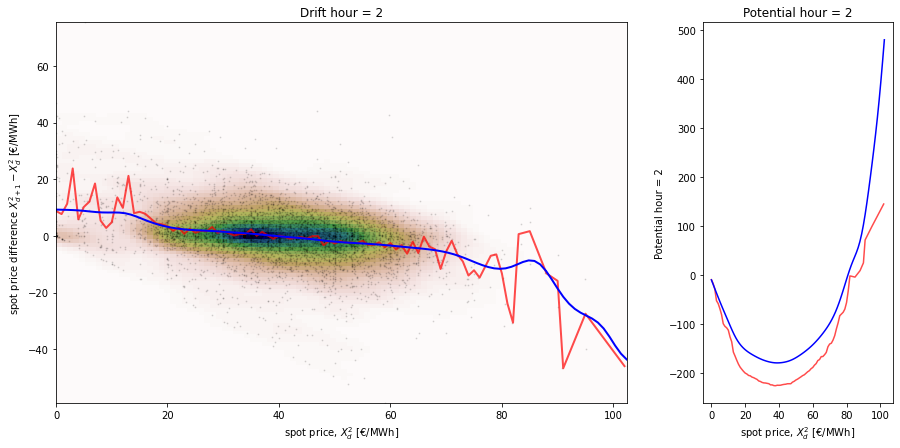

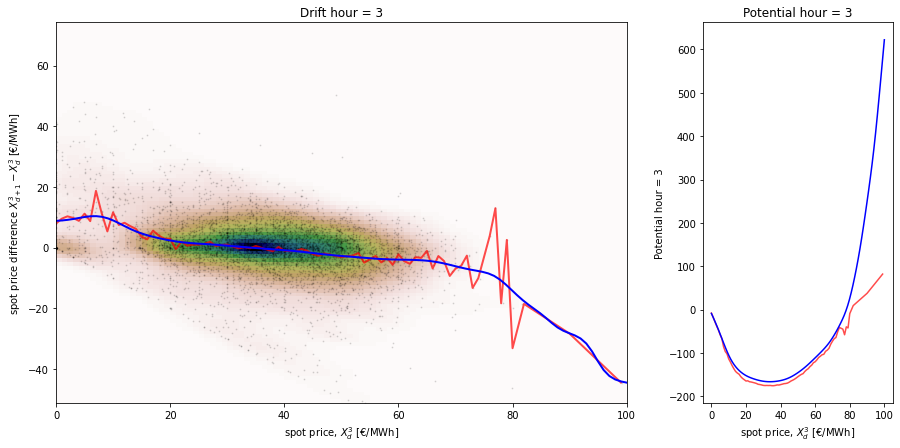

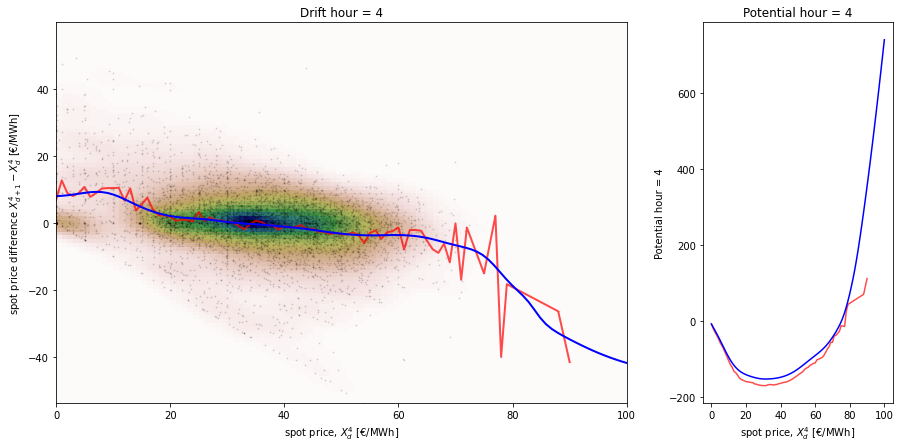

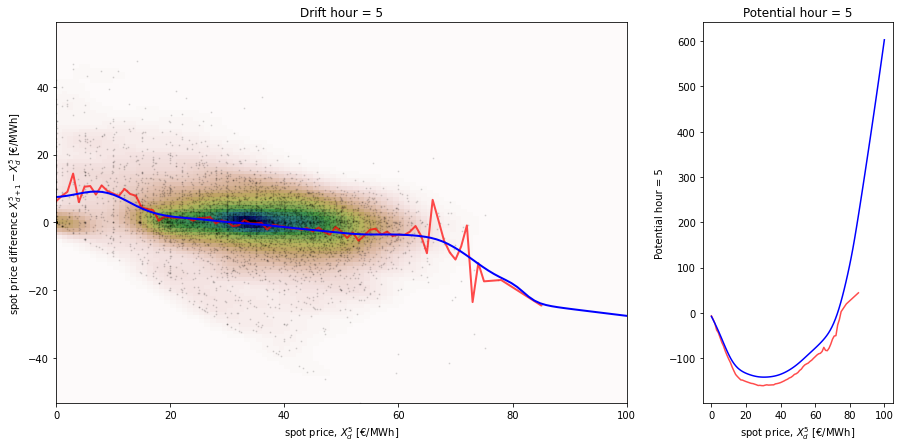

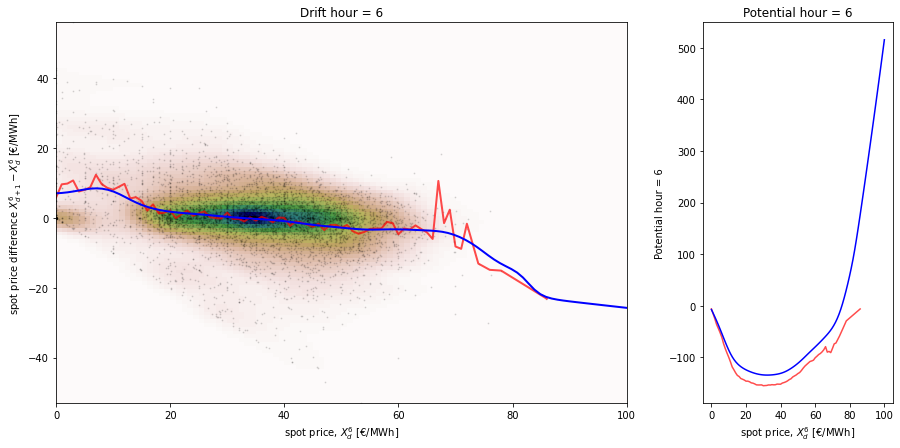

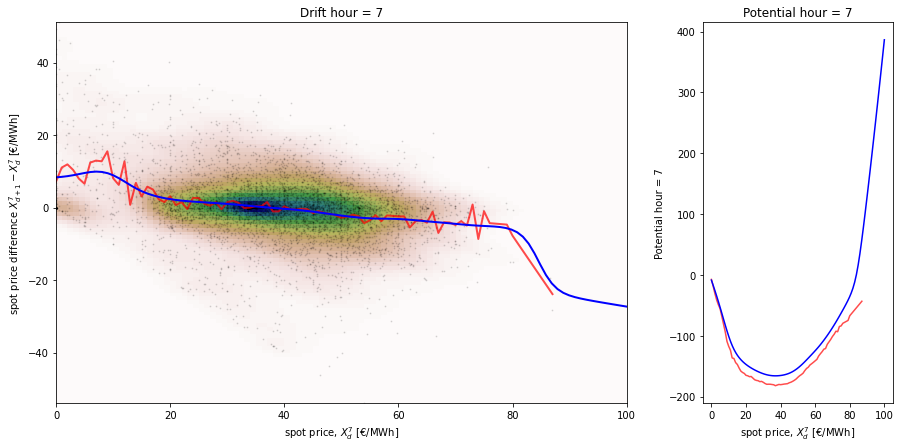

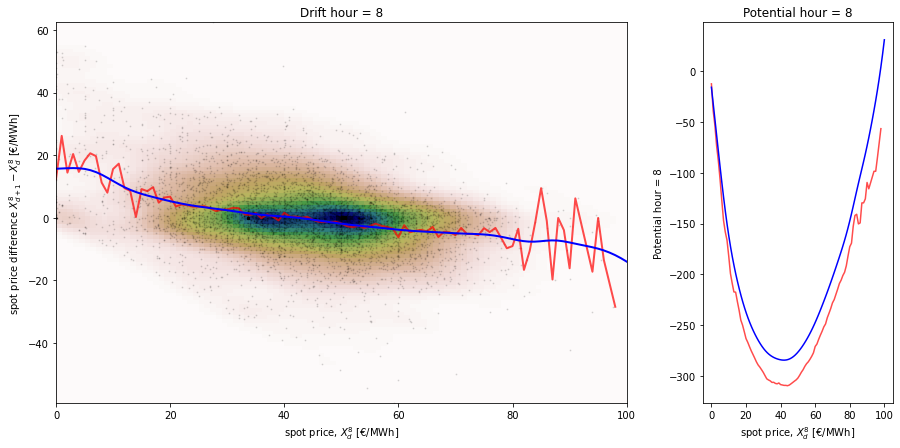

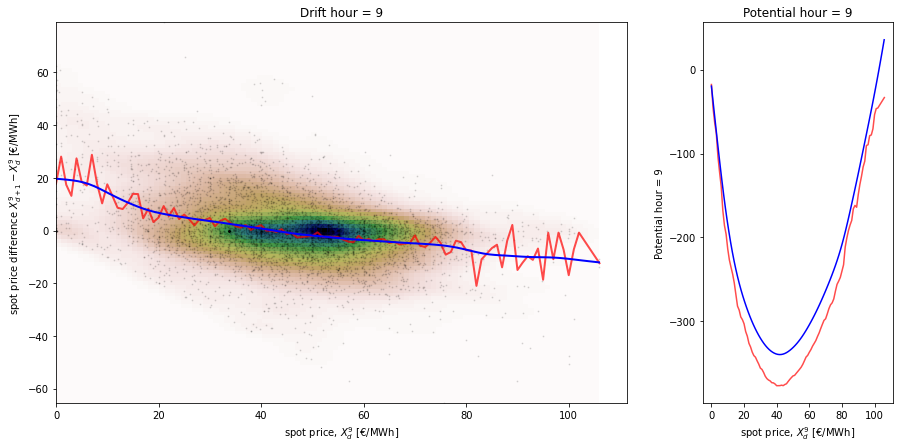

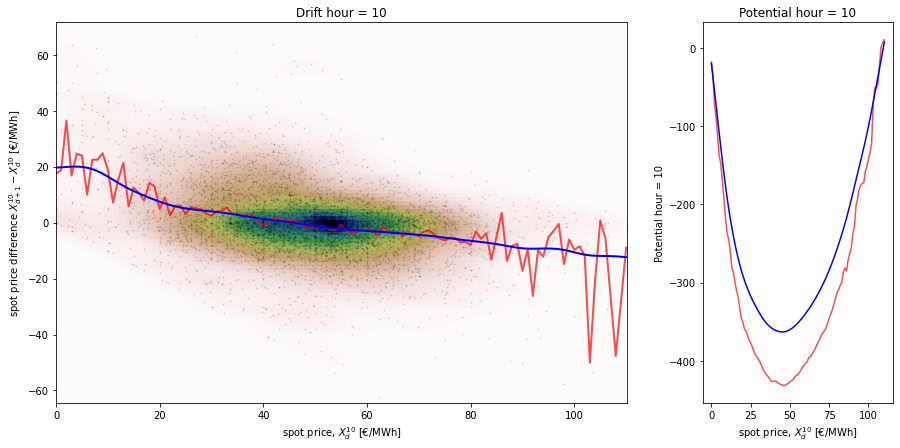

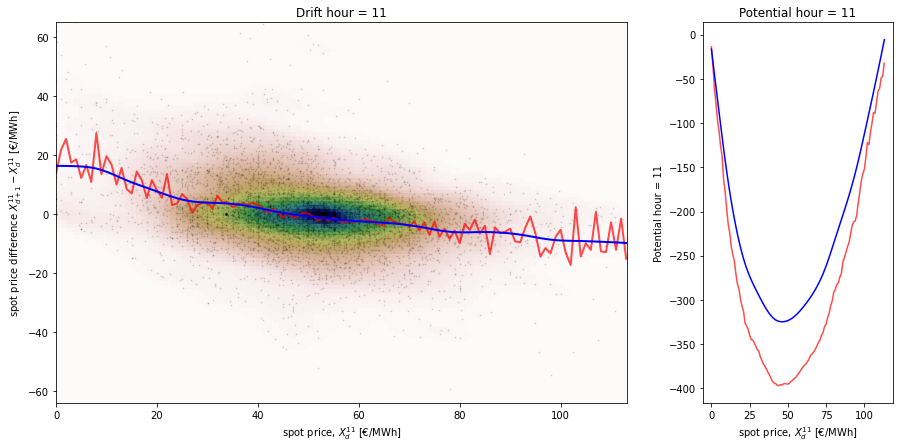

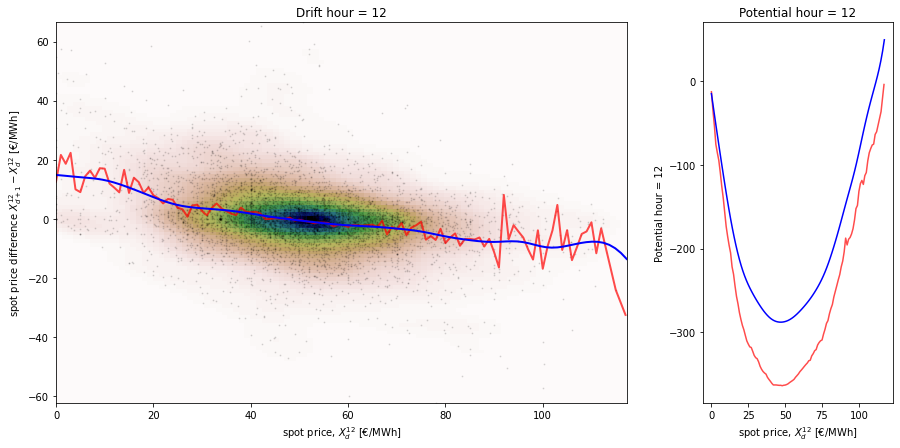

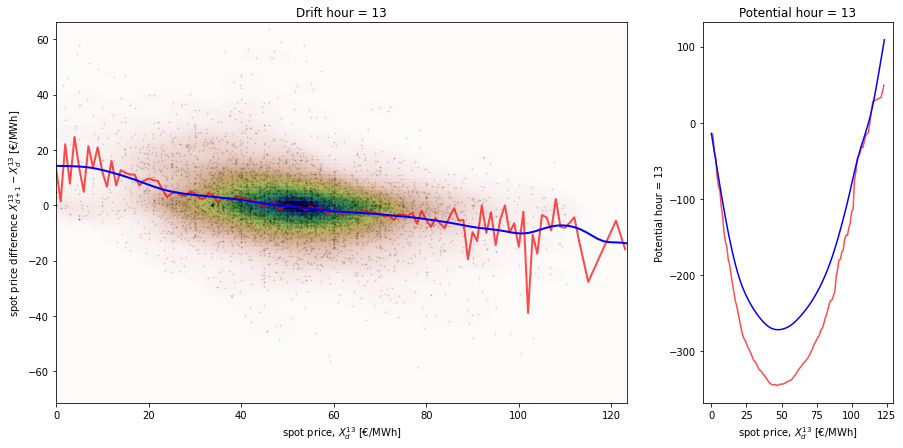

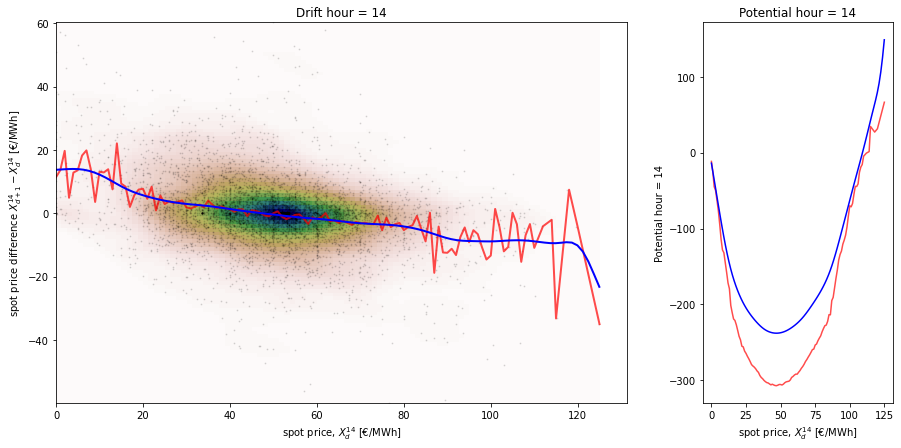

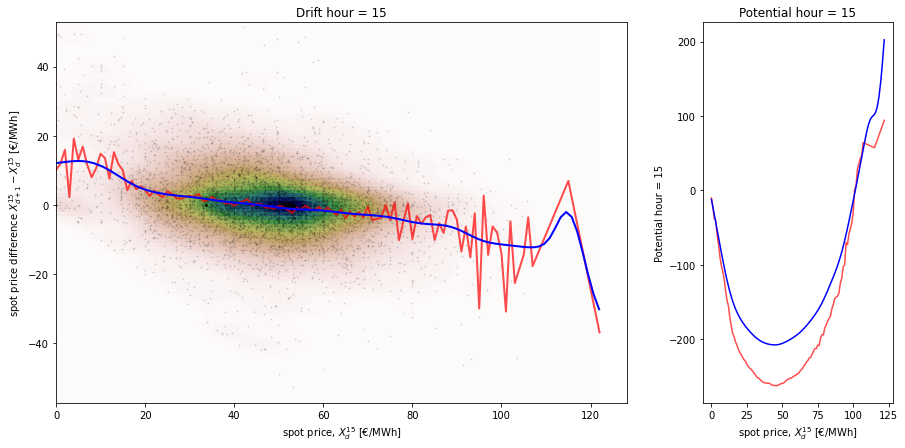

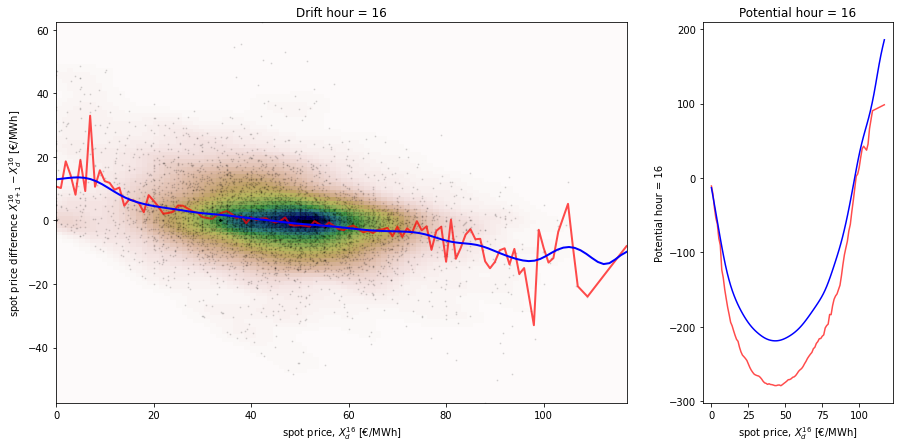

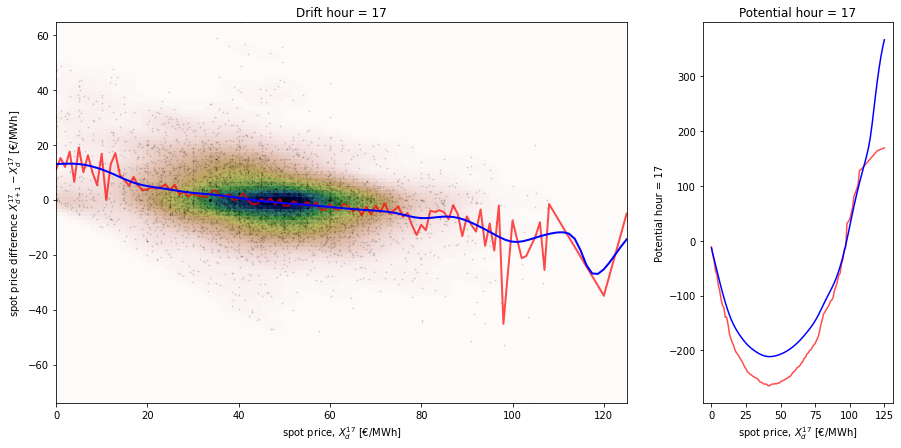

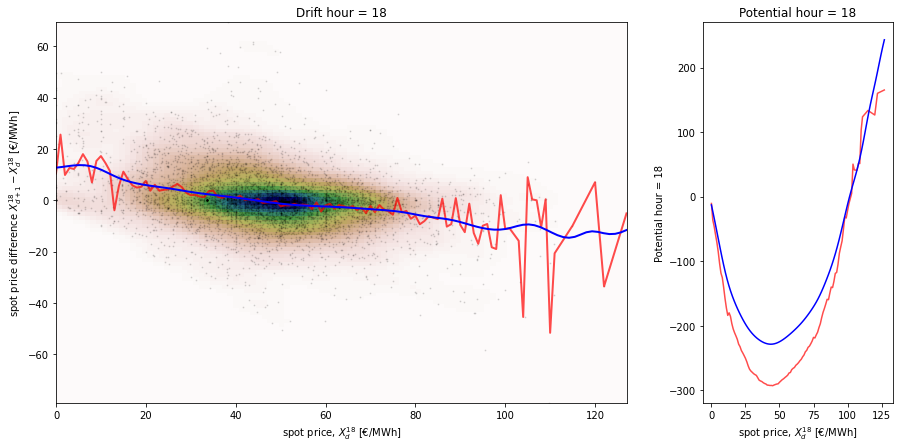

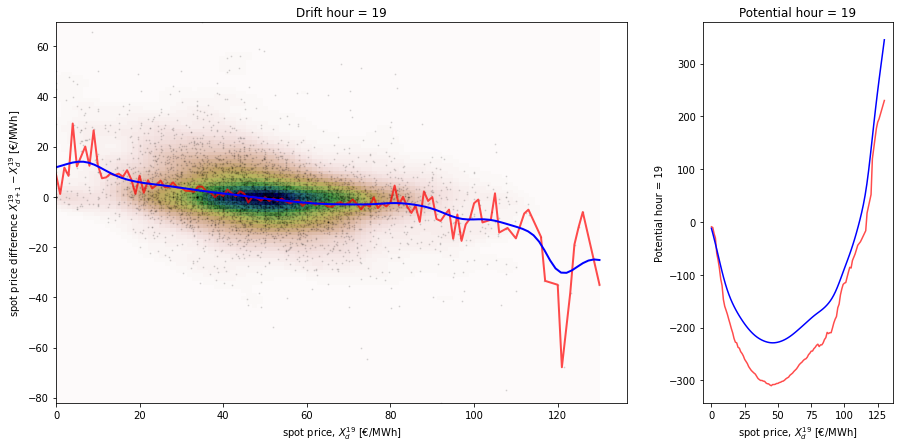

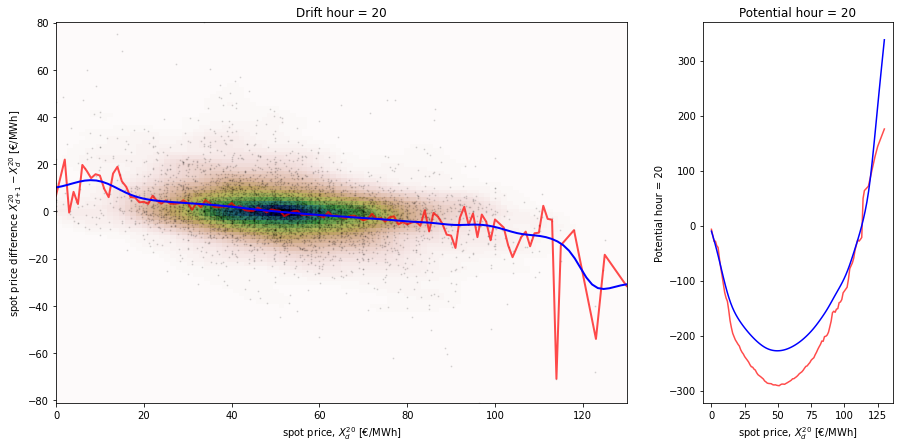

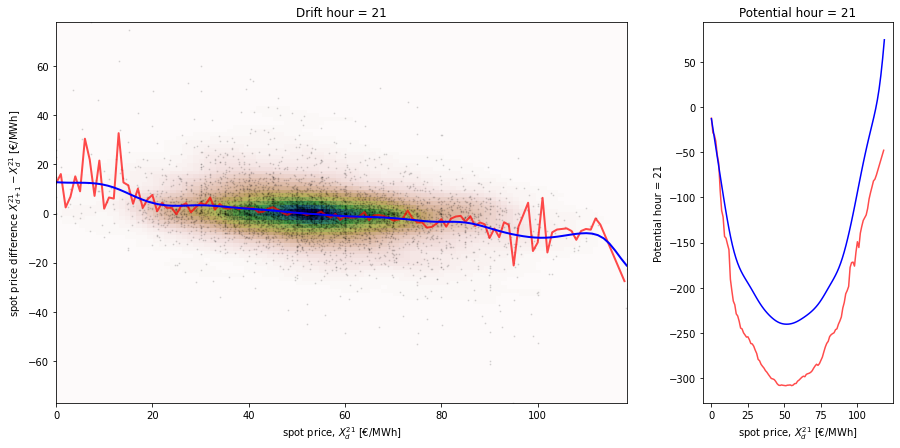

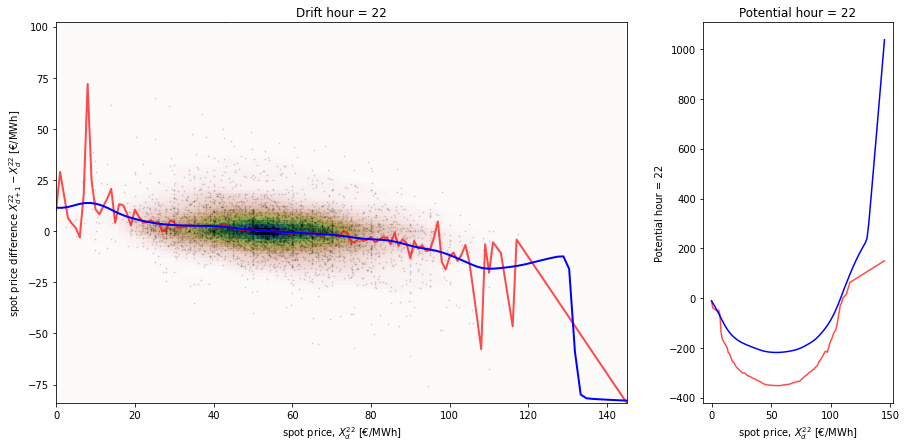

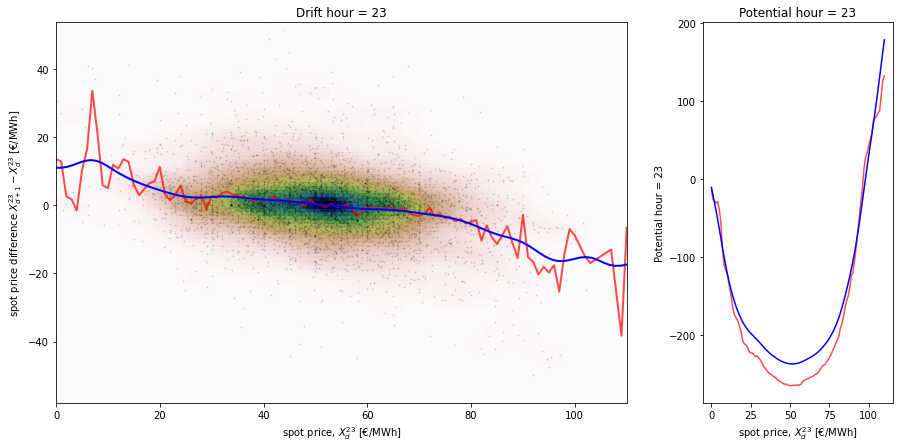

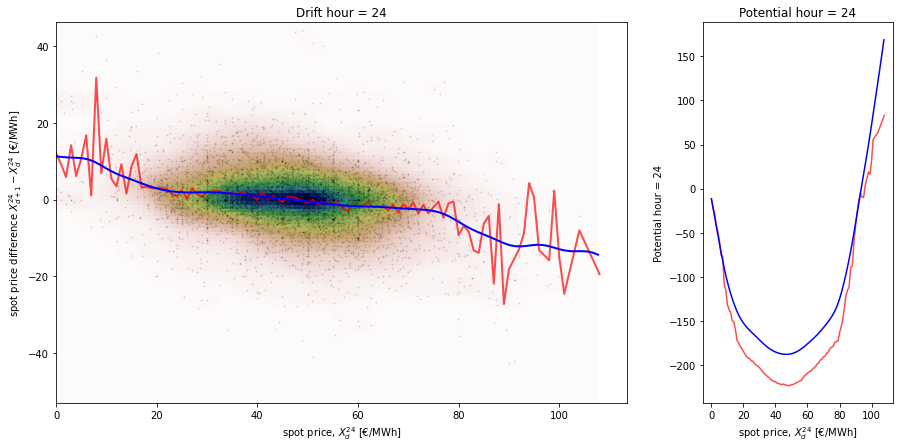

In [144]:
hour_stats = {}
for h in s.df["hour"].unique():
    x_y = s.df.query(f"hour == {h}")[["spain", "drift_24"]].dropna()
    values = x_y.values.T
    
    xmin = values[0].min().round(2)
    xmax = values[0].max().round(2)
    xmax = xmax if xmax >= 100 else 100
    ymin = values[1].min().round(2)
    ymax = values[1].max().round(2)

    kernel = stats.gaussian_kde(values)

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    
    Z = np.reshape(kernel(positions).T, X.shape)
    
    x_range = X[:, 0]
    x_mean_price_change = np.zeros_like(x_range)
    x_empirical_price_change = s.df.query(f"hour == {h}").groupby("x_label")["drift_24"].mean()
    #x_max_prob = np.zeros_like(x_range)
    for i, x in enumerate(x_range):
        # this computes the expected value even if the probability (weights) are not normalised 
        # https://numpy.org/doc/stable/reference/generated/numpy.average.html
        x_mean_price_change[i] = np.average(Y[i], weights=Z[i])
        #x_max_prob[i] = Y[i][np.argmax(Z[i])
        
    hour_stats[h] = {
        "values":values,
        "Z": Z,
        "xmin": xmin,
        "xmax": xmax,
        "ymin": ymin,
        "ymax": ymax,
        "x_empirical_price_change": x_empirical_price_change,
        "x_range": x_range,
        "x_mean_price_change": x_mean_price_change
    }
        
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [3, 1]})
    
    plot_gaussian_kde_mean_price_change(ax=ax0, h_stats=hour_stats[h])
    ax0.set_xlabel(f"spot price, $X_d^{{{h}}}$ [€/MWh]")
    ax0.set_ylabel(f"spot price difference $X_{{d+1}}^{{{h}}} - X_{{d}}^{{{h}}}$ [€/MWh]")
    ax0.set_title(f"Drift hour = {h}")
    
    plot_potential(ax=ax1, h_stats=hour_stats[h])
    ax1.set_title(f"Potential hour = {h}")
    ax1.set_xlabel(f"spot price, $X_d^{{{h}}}$ [€/MWh]")
    ax1.set_ylabel(f"Potential")
    

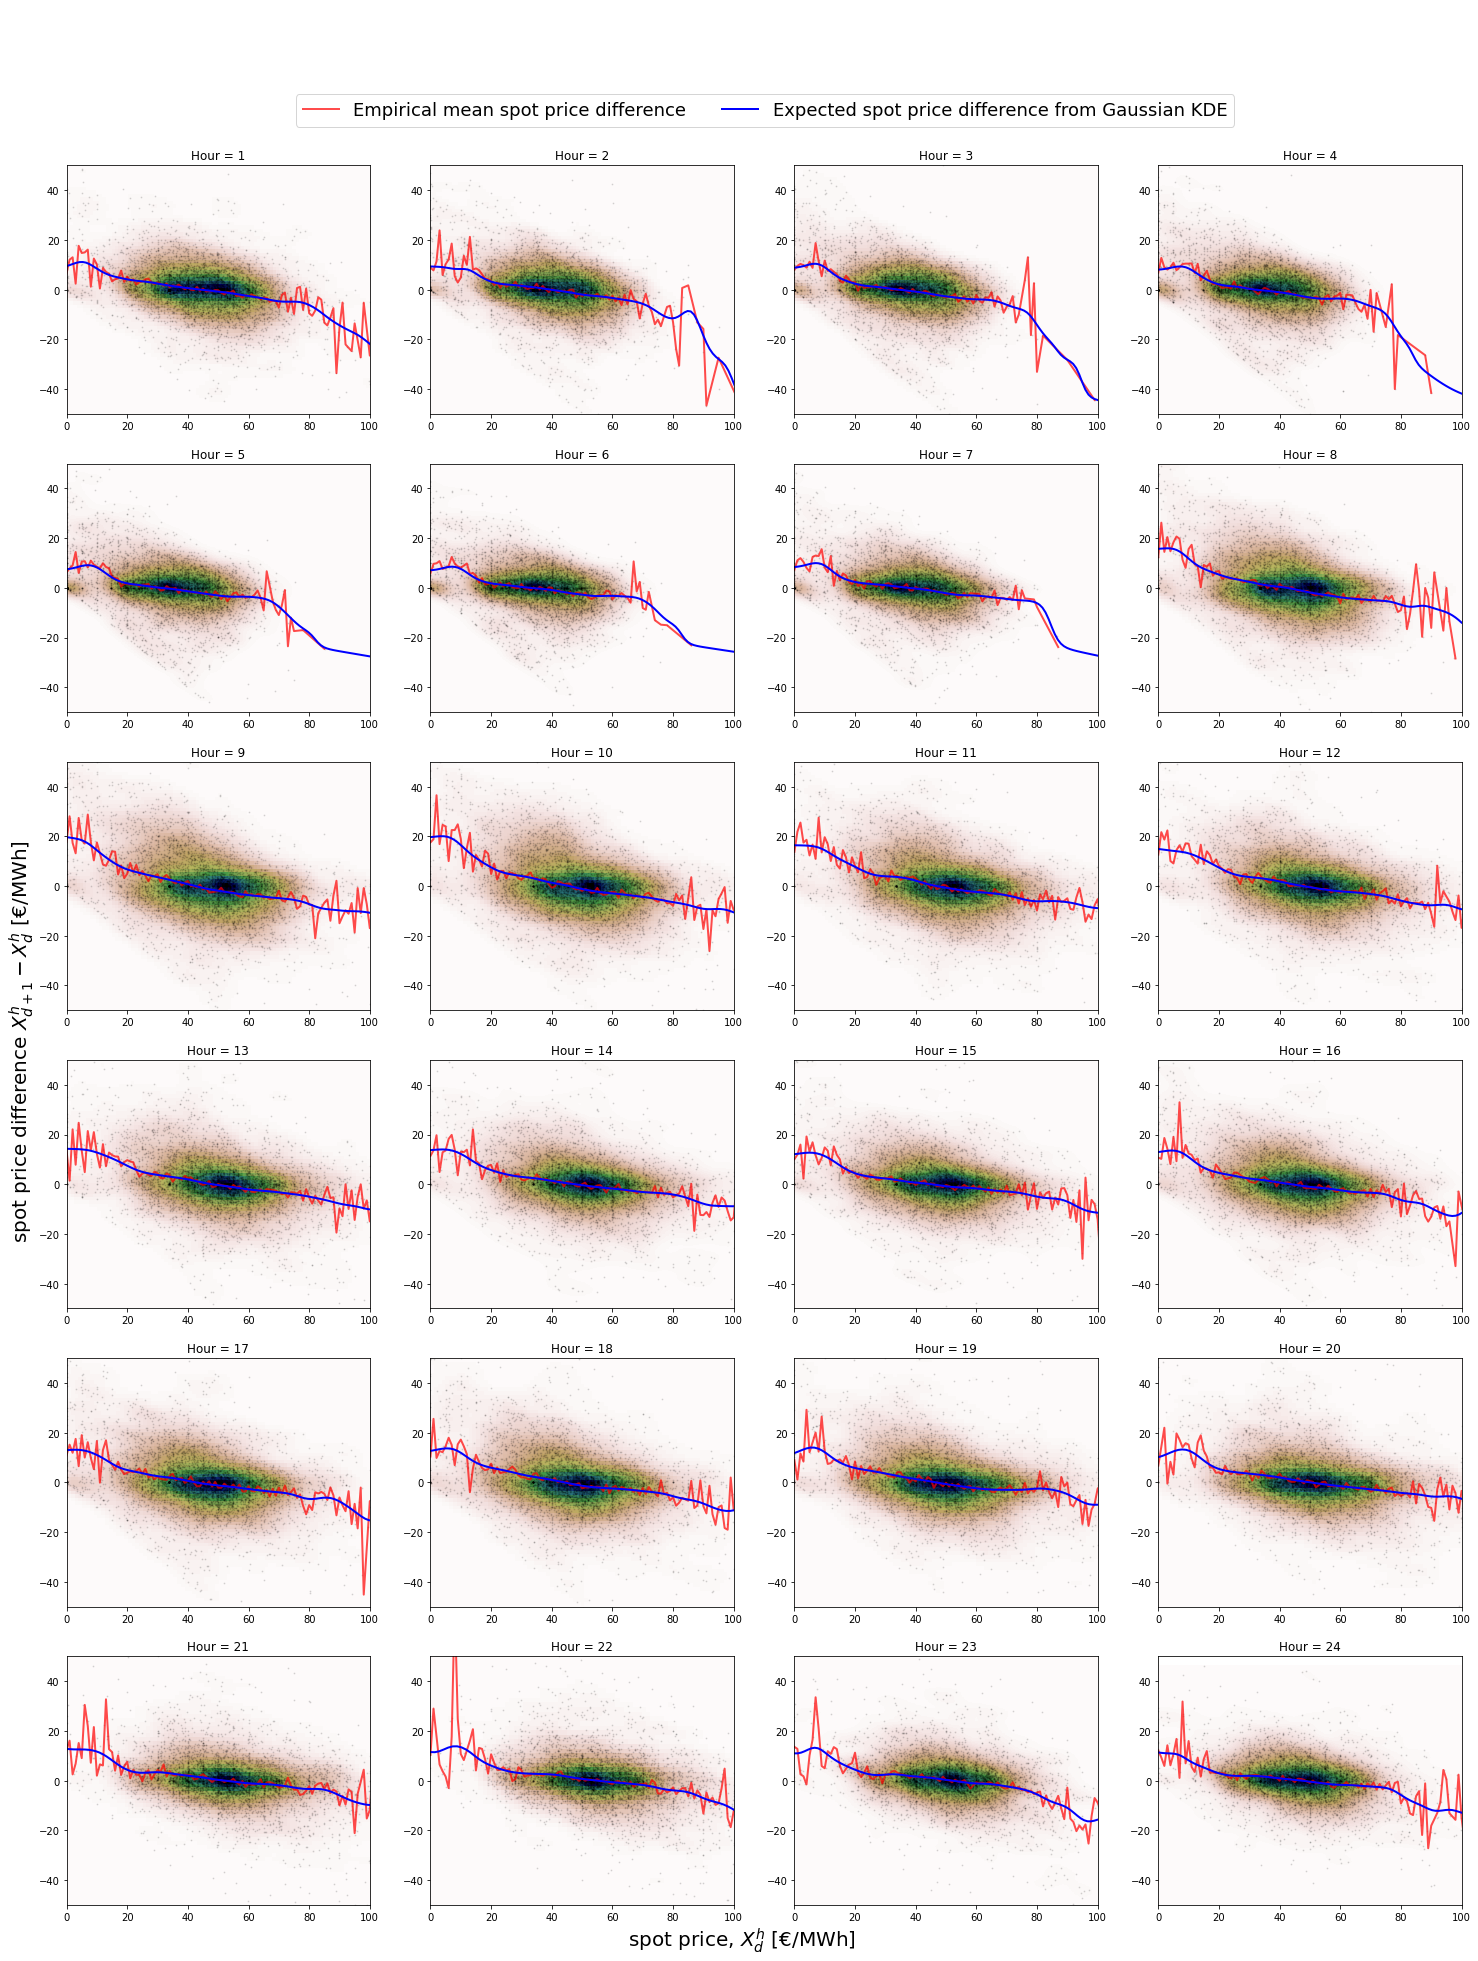

In [140]:
fig, axis = plt.subplots(6, 4, figsize=(25, 32))

xnew = np.arange(0, 150) 
for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*4+j
        plot_gaussian_kde_mean_price_change(ax=ax, h_stats=hour_stats[h], h=h)
        ax.set_title(f"Hour = {h}")
        ax.set_xlim(0, 100)
        ax.set_ylim(-50, 50)

fig.text(0.5, 0.11, "spot price, $X_d^{h}$ [€/MWh]", ha="center", va="center", fontdict={"size": 20})
fig.text(0.1, 0.5, "spot price difference $X_{d+1}^{h} - X_{d}^{h}$ [€/MWh]", ha="center", va="center",
         fontdict={"size": 20}, rotation=90)

custom_lines = [Line2D([0], [0], color="red", lw=2, alpha=0.7),
                Line2D([0], [0], color="blue", lw=2)]
fig.legend(custom_lines, 
           ["Empirical mean spot price difference", "Expected spot price difference from Gaussian KDE"],
           ncol=2, loc = (0.2, 0.935), prop={"size": 18})
plt.show()

$$ D_2^h $$

### Cubic splines - Potential as a function of spot price difference

In [ ]:
s_back_drift.drift_hour_x.loc[12].plot()

In [ ]:
s_back_drift.potential_hour_x.loc[12].plot()

In [ ]:
potential_diff = s_back_drift.potential_hour_x.loc[12]
potential_diff = potential_diff.dropna()

x = potential_diff.index.values
y = potential_diff.values

xnew = np.arange(-60, 60)

smooth_values = [0, 10, 100, 1000, 10000, 100000, 1000000] + [len(x) - np.sqrt(2*len(x))]
#smooth_values = [5000]
smooth_values.sort()
for sm_v in smooth_values:
    tck = interpolate.splrep(x, y, s=sm_v, k=3)
    ynew = interpolate.splev(xnew, tck, der=0)
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 3))
    ax0.plot(xnew, ynew, 'b', x, y, 'r')
    ax0.set_title("potential")
    
    yder = interpolate.splev(xnew, tck, der=1)
    ax1.plot(xnew, (-1)*yder)
    ax1.set_title("drift")
    fig.suptitle(f"s = {sm_v}")

In [ ]:
fig, axis = plt.subplots(6, 4, figsize=(20, 20))

xnew = np.arange(-80, 80) 
for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        hour = 1 + i*4+j
        potential_diff = s_back_drift.potential_hour_x.loc[hour]
        potential_diff.plot(ax=ax, color='r')
        potential_diff = potential_diff.dropna()
        x = potential_diff.index.values
        y = potential_diff.values
        
        tck = interpolate.splrep(x, y, s=10**5, k=3)
        
        ynew = interpolate.splev(xnew, tck, der=0)
        ax.plot(xnew, ynew, 'b')
        ax.set_title(f"potential hour - {hour}")

Compute price inflation as mean daily prices - mean drfit and learn this through a neural ODE